In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
from tqdm import tqdm
from gaze_utility import calculate_dist_and_veloc
from fixation import generate_IVT_fixation
from preprocessing import remove_outlier_by_z, get_participant_names
from gaze_plot import fixation_based_plot, grid_based_plot

# global variables
data_path = 'data/'
exp_img_path = 'exp-img/'
result_path = 'result/'
rank_result_path = 'rank-result/'
events = ['gaze_grid_1', 'gaze_ranking_grid_1', 'gaze_grid_2', 'gaze_ranking_grid_2']
exps = ['grid_1', 'grid_2']
xn = 'GazeX'
yn = 'GazeY'
rect_dict = {'tl': 1,
             'tm': 2,
             'tr': 3,
             'bl': 4,
             'bm': 5,
             'br': 6,}

# get participant names
names = get_participant_names(data_path)
print('participants names: ', names)
print('participant num: ', len(names))

# generate grid img
if not os.listdir(exp_img_path):
    from generate_experiment_img import *
    for file_name in click_rank_files:
        generate_grid_iamge(get_grid_image_order(data_path, file_name))

participants names:  ['an', 'hw', 'mr', 'yq', 'yx', 'dao', 'lr', 'lf', 'ts', 'xiao', 'mh', 'hu', 'yz', 'jt', 'co', 'huy']
participant num:  16


# Single Anaylsis （for test)

<AxesSubplot:xlabel='GazeX', ylabel='GazeY'>

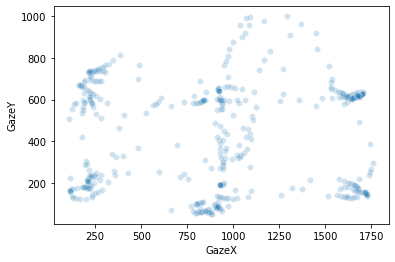

In [2]:
# take grid1 of for example
name = 'lf'
exp = 'grid_2'
exp_img = mpimg.imread(exp_img_path + name + '_' + exp + '.jpg')
gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
data = gaze_data.loc[gaze_data['record_event'] == 'gaze_grid_1']
sns.scatterplot(x=xn, y=yn, data=data, alpha=0.2)

In [3]:
data.head()

,GazeX,GazeY,HeadX,HeadY,HeadZ,HeadYaw,HeadPitch,HeadRoll,rx,ry,rw,rh,state,time,FrameNr,Xview,Yview,docX,docY,record_event
0,1084.8,957.0,-1.0,-1.5,41.1,0.5,1.8,2.0,145,136,312,312,0,1597777008499,4780,0.565000,0.797500,1084.8,957.0,gaze_grid_1
1,1066.2,918.6,-1.0,-1.5,41.0,0.6,2.0,1.9,145,136,312,312,0,1597777008531,4781,0.555312,0.765500,1066.2,918.6,gaze_grid_1
2,1168.0,979.6,-1.0,-1.4,40.4,0.7,2.1,1.8,145,136,312,312,0,1597777008619,4782,0.608333,0.816333,1168.0,979.6,gaze_grid_1
3,1165.2,791.2,-1.0,-1.6,40.9,0.7,2.6,1.7,145,136,312,312,0,1597777008740,4783,0.606875,0.659333,1165.2,791.2,gaze_grid_1
4,1103.2,518.8,-1.0,-1.6,40.9,0.7,2.8,1.8,144,134,315,315,0,1597777008780,4784,0.574583,0.432333,1103.2,518.8,gaze_grid_1


<AxesSubplot:xlabel='GazeX', ylabel='GazeY'>

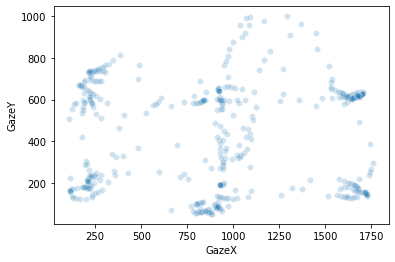

In [4]:
# drop NaN (happened in 'co' data)
data.dropna(inplace=True)
# remove outlier
data = remove_outlier_by_z(data, xn)
data = remove_outlier_by_z(data, yn)

sns.scatterplot(x=xn, y=yn, data=data, alpha=0.2)

0.1    68
0.2    63
0.4    44
0.3    41
0.0    34
Name: velocity, dtype: int64


<AxesSubplot:xlabel='velocity'>

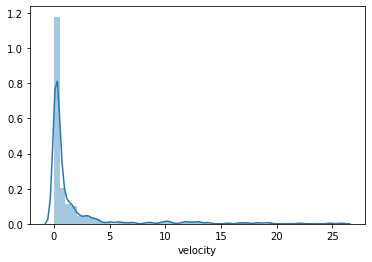

In [5]:
# calculate dist, velocity, time passed
data['distance'], data['velocity'], data['time_pass'] = calculate_dist_and_veloc(data)

v = data['velocity'].round(1)
print(v.value_counts().head())
sns.distplot(v)

<AxesSubplot:>

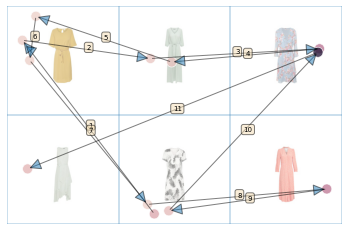

In [6]:
fixation_based_plot(data=data, v_th=0.5, d_th=300, xn=xn, yn=yn, background=exp_img)

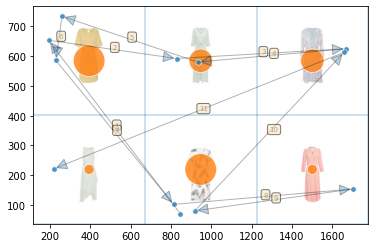

In [7]:
_, grid = grid_based_plot(data=data, v_th=0.5, d_th=300, xn=xn, yn=yn, background=exp_img)

# Batch Analysis

In [8]:
dist_rank = []

# plot
for name in tqdm(names):
    gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
    for event in events:
        # log
        print('start: ' + name + '-' + event)
        # load data
        data = gaze_data.loc[gaze_data['record_event'] == event]
        # drop NaN (happened in 'co' data)
        data.dropna(inplace=True)
        # remove outlier
        data = remove_outlier_by_z(data, xn)
        data = remove_outlier_by_z(data, yn)
        # construct attr
        data['distance'], data['velocity'], data['time_pass'] = calculate_dist_and_veloc(data)
        # select experiment grid img
        if exps[0] in event: exp = exps[0]
        else: exp = exps[1]
        exp_img = mpimg.imread(exp_img_path + name + '_' + exp + '.jpg')
        
        # fixation-based plot
        fixation_based_plot(data, v_th=0.5, d_th=300, xn=xn, yn=yn, background=exp_img)
        plt.savefig(result_path + name + '_' + event + '_F_plot.png', format='png')
        plt.clf()

        # grid-based plot
        if 'ranking' not in event: # (only for gaze)
            _, grid = grid_based_plot(data, v_th=0.5, d_th=300, xn=xn, yn=yn, background=exp_img)
            plt.savefig(result_path + name + '_' + event + '_G_plot.png', format='png')
            plt.clf()

            rank = [{rect_dict[k]: v['time_sum']} for k, v in sorted(grid.items(), key=lambda item: -item[1]['time_sum'])]
            dist_rank.append({
                'name': name,
                'event': event,
                'rank': rank,
            })

        # log
        print('finish: ' + name + '-' + event)

# distribution rank
dist_rank = pd.DataFrame(dist_rank)
dist_rank.to_csv(rank_result_path + 'dist_rank.csv', index=None)

start: hw-gaze_grid_1
finish: hw-gaze_grid_1
start: hw-gaze_ranking_grid_1
finish: hw-gaze_ranking_grid_1
start: hw-gaze_grid_2
finish: hw-gaze_grid_2
start: hw-gaze_ranking_grid_2
finish: hw-gaze_ranking_grid_2
start: lr-gaze_grid_1
finish: lr-gaze_grid_1
start: lr-gaze_ranking_grid_1
finish: lr-gaze_ranking_grid_1
start: lr-gaze_grid_2
finish: lr-gaze_grid_2
start: lr-gaze_ranking_grid_2
finish: lr-gaze_ranking_grid_2
start: mh-gaze_grid_1
finish: mh-gaze_grid_1
start: mh-gaze_ranking_grid_1
finish: mh-gaze_ranking_grid_1
start: mh-gaze_grid_2
finish: mh-gaze_grid_2
start: mh-gaze_ranking_grid_2
finish: mh-gaze_ranking_grid_2
start: ts-gaze_grid_1
finish: ts-gaze_grid_1
start: ts-gaze_ranking_grid_1
finish: ts-gaze_ranking_grid_1
start: ts-gaze_grid_2
finish: ts-gaze_grid_2
start: ts-gaze_ranking_grid_2
finish: ts-gaze_ranking_grid_2
start: huy-gaze_grid_1
finish: huy-gaze_grid_1
start: huy-gaze_ranking_grid_1
finish: huy-gaze_ranking_grid_1
start: huy-gaze_grid_2
finish: huy-gaze_gr

<Figure size 432x288 with 0 Axes>

# Stats

In [2]:
tick_fontsize = 12
label_fontsize = 14

In [3]:
all_v = []
for name in tqdm(names):
    gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
    for event in events:
        if 'ranking' in event: continue
        # load data
        data = gaze_data.loc[gaze_data['record_event'] == event]
        # drop NaN (happened in 'co' data)
        data.dropna(inplace=True)
        # remove outlier
        data = remove_outlier_by_z(data, xn)
        data = remove_outlier_by_z(data, yn)
        # construct attr
        _, v, _ = calculate_dist_and_veloc(data)
        v = [round(x, 1) for x in v]
        all_v.extend(v)

100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


0.1    3103
0.2    2296
0.3    1558
0.4    1049
0.0     852
0.5     798
0.6     590
0.7     439
0.8     353
0.9     294
dtype: int64


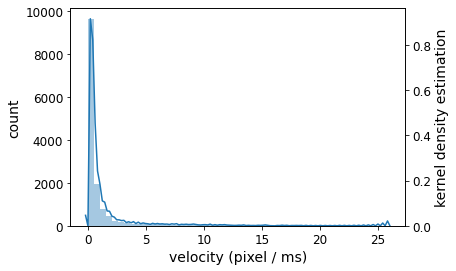

In [4]:
all_v = pd.Series(all_v)
print(all_v.value_counts().head(10))
ax = sns.distplot(all_v, kde=False)
plt.xlabel('velocity (pixel / ms)', fontsize=label_fontsize)
plt.ylabel('count', axes=ax, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
ax2 = ax.twinx()
sns.kdeplot(all_v, ax=ax2)
plt.ylabel('kernel density estimation', axes=ax2, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.savefig('stats/velocity_distribution', dpi=300, bbox_inches='tight')

In [5]:
all_d = []

for name in tqdm(names):
    gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
    for event in events:
        if 'ranking' in event: continue
        # load data
        data = gaze_data.loc[gaze_data['record_event'] == event]
        # drop NaN (happened in 'co' data)
        data.dropna(inplace=True)
        # remove outlier
        data = remove_outlier_by_z(data, xn)
        data = remove_outlier_by_z(data, yn)
        # construct attr
        data['distance'], data['velocity'], data['time_pass'] = calculate_dist_and_veloc(data)
        fixations = generate_IVT_fixation(data, v_th=0.5, d_th=0)
        durations = [f['duration'] for f in fixations]
        all_d.extend(durations)

100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


100.0    580
200.0    242
0.0      165
300.0    141
400.0    106
500.0     67
600.0     38
700.0     26
800.0     21
900.0     14
dtype: int64


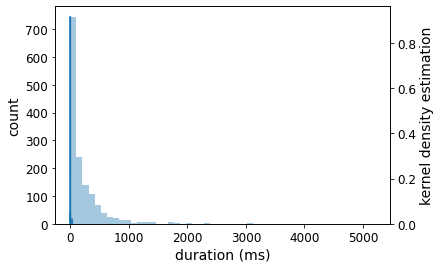

In [6]:
all_d = [round(d, -2) for d in all_d]
all_d = pd.Series(all_d)
print(all_d.value_counts().head(10))
ax = sns.distplot(all_d, kde=False)
plt.xlabel('duration (ms)', fontsize=label_fontsize)
plt.ylabel('count', axes=ax, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
ax2 = ax.twinx()
sns.kdeplot(all_v, ax=ax2)
plt.tick_params(labelsize=tick_fontsize)
plt.ylabel('kernel density estimation', axes=ax2, fontsize=label_fontsize)
plt.savefig('stats/duration_distribution', dpi=300)